### Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

### utils

In [2]:
## Set random seed
def set_seed(seed=42):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## Data Preparation
def read_data(dataPath):
    data = pd.read_csv(dataPath).drop('Unnamed: 0',axis=1).rename(columns={'index': 'Seq'})
    data['Position'] = data['Position'].replace(np.nan, '{}')
    data['Position'] = data['Position'].apply(ast.literal_eval)
    return data

def prepare_data(data, max_positions=16):
    # Standardization
    data[['A2P', 'A1P', 'B1P', 'B2P', 'Price']] = data[['A2P', 'A1P', 'B1P', 'B2P', 'Price']] / 1e4
    data[['A2V', 'A1V', 'B1V', 'B2V', 'Volume']] = np.log(data[['A2V', 'A1V', 'B1V', 'B2V', 'Volume']])
    
    # lob_cols = ['A2P', 'A2V', 'A1P', 'A1V', 'B1P', 'B1V', 'B2P', 'B2V']
    lob_cols = ['A2P', 'A1P', 'B1P', 'B2P', 'A2V', 'A1V', 'B1V', 'B2V']
    state_cols = ['Cash', 'Inventory']
    action_cols = ['Price', 'Volume', 'Type', 'Direction']

    # Flatten positions
    def flatten_position_vectorized(position_series, max_positions):
        def flatten_pos(pos):
            if len(pos) == 0:
                return np.zeros(3 * max_positions)
            else:
                pos_array = np.array(list(pos.values()), dtype=float)
                pos_array[:, 0] /= 1e4  # Scale prices
                pos_array[:, 1] = np.log(pos_array[:, 1])
                pos_array[:, 2] = pos_array[:, 3]
                pos_array[:, 2] = np.log(pos_array[:, 2] + 1)
                pos_array = pos_array[:, :-1]
                flat_position = pos_array.flatten()
                if len(flat_position) < 3 * max_positions:
                    flat_position = np.concatenate([flat_position, np.zeros(3 * max_positions - len(flat_position))])
                return flat_position[:3 * max_positions]
        
        tqdm.pandas(desc='apply')
        flattened = position_series.progress_apply(flatten_pos)
        return np.stack(flattened.values)

    flattened_positions = flatten_position_vectorized(data['Position'], max_positions)
    
    # Prepare observations and next observations
    observations = np.concatenate([data[state_cols].values, data[lob_cols].values, flattened_positions], axis=1)
    next_observations = data[lob_cols].shift(-1).iloc[:-1].values

    # Prepare actions
    actions = data[action_cols].iloc[:-1]
    actions = pd.get_dummies(actions, columns=['Type', 'Direction']).values

    observations = torch.tensor(observations[:-1], dtype=torch.float32)
    actions = torch.tensor(actions.astype(float), dtype=torch.float32)
    next_observations = torch.tensor(next_observations.astype(float), dtype=torch.float32)
    
    return observations, actions, next_observations

class CustomDataset(Dataset):
    def __init__(self, observations, actions, next_observations):
        self.observations = observations
        self.actions = actions
        self.next_observations = next_observations
    
    def __len__(self):
        return len(self.observations)
    
    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx], self.next_observations[idx]

# Standardisation within each batch
def batch_standardize(batch):
    observations, actions, next_observations = zip(*batch)
    
    observations = torch.stack(observations)
    actions = torch.stack(actions)
    next_observations = torch.stack(next_observations)
    
    # Standardize within the batch
    observations_mean = observations.mean(dim=0)
    observations_std = observations.std(dim=0)
    actions_mean = actions.mean(dim=0)
    actions_std = actions.std(dim=0)
    next_obs_mean = next_observations.mean(dim=0)
    next_obs_std = next_observations.std(dim=0)

    # Avoid division by zero
    observations_std[observations_std == 0] = 1
    actions_std[actions_std == 0] = 1
    next_obs_std[next_obs_std == 0] = 1
    
    standardized_observations = (observations - observations_mean) / observations_std
    standardized_actions = (actions - actions_mean) / actions_std
    standardized_next_observations = (next_observations - next_obs_mean) / next_obs_std

    standardized_actions = torch.nan_to_num(standardized_actions, nan=0.0)
    
    return standardized_observations, standardized_actions, standardized_next_observations, next_obs_mean, next_obs_std


# split the dataset into training, validating and testing
def split_dataset(observations, actions, next_observations, train_size=0.7, val_size=0.15):
    # Split into train + validation and test
    obs_train, obs_temp, act_train, act_temp, next_obs_train, next_obs_temp = train_test_split(
        observations, actions, next_observations, test_size=(1 - train_size), random_state=42, shuffle=False
    )
    
    # Split temp into validation and test
    val_size_adj = val_size / (1 - train_size)  # Adjust validation size based on remaining data
    obs_val, obs_test, act_val, act_test, next_obs_val, next_obs_test = train_test_split(
        obs_temp, act_temp, next_obs_temp, test_size=(1 - val_size_adj), random_state=42, shuffle=False
    )
    
    return obs_train, obs_val, obs_test, act_train, act_val, act_test, next_obs_train, next_obs_val, next_obs_test

def evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim):
    autoencoder.eval()
    total_test_loss = 0
    criterion = nn.MSELoss()

    predictions = []
    actuals = []
    
    with torch.no_grad():
        prev_state = torch.zeros((batch_size, state_dim))
        prev_action = torch.zeros((batch_size, action_dim))
        for obs, action, next_obs, next_obs_mean, next_obs_std in test_loader:
            prediction, state = autoencoder(obs, action, prev_state, prev_action)
            loss = criterion(prediction, next_obs)
            total_test_loss += loss.item()
            prev_state = state.detach()
            prev_action = action.detach()
            restored_prediction = (prediction * next_obs_std) + next_obs_mean
            restored_actual = (next_obs * next_obs_std) + next_obs_mean
            restored_prediction[:, :4] = torch.round(restored_prediction[:, :4], decimals=2)
            restored_actual[:, :4] = torch.round(restored_actual[:, :4], decimals=2)
            restored_prediction[:, -4:] = torch.round(torch.exp(restored_prediction[:, -4:]))
            restored_actual[:, -4:] = torch.round(torch.exp(restored_actual[:, -4:]))
            predictions.append(restored_prediction.numpy())
            actuals.append(restored_actual.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    avg_test_loss = total_test_loss / len(test_loader)
    print('---')
    print(f'Test Loss: {avg_test_loss:.4f}')

    # Output the first few predictions and actuals for inspection
    for i in range(5):
        print('---')
        print(f"Prediction {i+1}: {predictions[i]}")
        print(f"Actual {i+1}: {actuals[i]}")


### Hyperparameters and Data Initialisation

In [3]:
set_seed(42)
data = read_data('/Users/sw/Working Space/Python/nmdp_rl/data/dataset_with_percentile/AAPL_2019-01-02_dataset_2ls.csv')
observations, actions, next_observations = prepare_data(data)
obs_train, obs_val, obs_test, act_train, act_val, act_test, next_obs_train, next_obs_val, next_obs_test = split_dataset(
    observations, actions, next_observations
)

# Hyperparameters
state_dim = 32
action_dim = actions.shape[1]
input_dim = observations.shape[1] + state_dim + action_dim
hidden_dim = input_dim
output_dim = next_observations.shape[1]
num_layers = 8  # Adjust the depth of the network
batch_size = 32
epochs = 50
learning_rate = 1e-4

output_dims = {'price': 4, 'volume': 4}  # Output dimensions for price and volume
attention_dim = input_dim
conv_filters = input_dim
kernel_size = 5

# Prepare DataLoader
train_dataset = CustomDataset(obs_train, act_train, next_obs_train)
val_dataset = CustomDataset(obs_val, act_val, next_obs_val)
test_dataset = CustomDataset(obs_test, act_test, next_obs_test)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False, collate_fn=batch_standardize, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, collate_fn=batch_standardize, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=batch_standardize, drop_last=True)

apply: 100%|██████████| 25413/25413 [00:00<00:00, 327335.24it/s]


### AE_simple

Epoch 1, Train Loss: 0.8409, Val Loss: 0.6776
Epoch 2, Train Loss: 0.6383, Val Loss: 0.6460
Epoch 3, Train Loss: 0.6288, Val Loss: 0.6450
Epoch 4, Train Loss: 0.6293, Val Loss: 0.6450
Epoch 5, Train Loss: 0.6283, Val Loss: 0.6437
Epoch 6, Train Loss: 0.6317, Val Loss: 0.6432
Epoch 7, Train Loss: 0.6312, Val Loss: 0.6428
Epoch 8, Train Loss: 0.6248, Val Loss: 0.6434
Epoch 9, Train Loss: 0.6290, Val Loss: 0.6425
Epoch 10, Train Loss: 0.6231, Val Loss: 0.6410
Epoch 11, Train Loss: 0.6232, Val Loss: 0.6442
Epoch 12, Train Loss: 0.6300, Val Loss: 0.6399
Epoch 13, Train Loss: 0.6319, Val Loss: 0.6399
Epoch 14, Train Loss: 0.6219, Val Loss: 0.6395
Epoch 15, Train Loss: 0.6232, Val Loss: 0.6397
Epoch 16, Train Loss: 0.6222, Val Loss: 0.6390
Epoch 17, Train Loss: 0.6216, Val Loss: 0.6390
Epoch 18, Train Loss: 0.6279, Val Loss: 0.6391
Epoch 19, Train Loss: 0.6213, Val Loss: 0.6390
Epoch 20, Train Loss: 0.6208, Val Loss: 0.6403
Epoch 21, Train Loss: 0.6249, Val Loss: 0.6387
Epoch 22, Train Loss: 

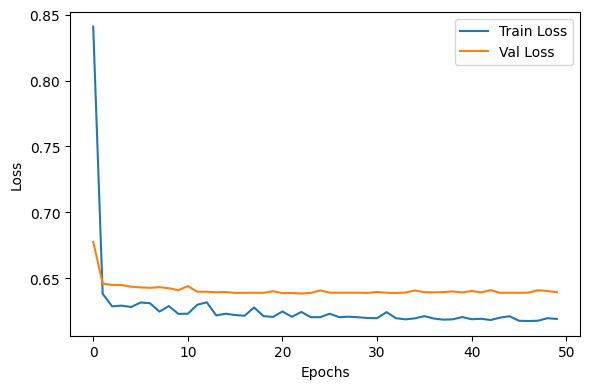

---
Test Loss: 0.6274
---
Prediction 1: [157.65 157.64 157.61 157.6   95.   107.   359.   322.  ]
Actual 1: [157.66 157.65 157.62 157.61   2.   302.   430.   861.  ]
---
Prediction 2: [157.66 157.64 157.62 157.6   93.   107.   362.   323.  ]
Actual 2: [157.66 157.65 157.61 157.6    2.   402.   961.   153.  ]
---
Prediction 3: [157.66 157.64 157.62 157.6   93.   107.   362.   323.  ]
Actual 3: [157.68 157.67 157.65 157.63 206.     4.   100.   200.  ]
---
Prediction 4: [157.67 157.66 157.63 157.62  91.   106.   365.   325.  ]
Actual 4: [157.65 157.64 157.61 157.6  100.    23.   961.   653.  ]
---
Prediction 5: [157.65 157.64 157.61 157.6   94.   107.   360.   322.  ]
Actual 5: [ 157.67  157.65  157.61  157.6   106.    100.   1361.     53.  ]


In [4]:
## Model definition
# Define the Encoder with configurable depth
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, num_layers):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_layers = nn.ModuleList()

        # Initialize hidden layers
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        if num_layers > 1:
            self.hidden_layers.append(nn.Linear(hidden_dim, state_dim))
        else:
            self.hidden_layers[0] = nn.Linear(input_dim, state_dim)
        # self.relu = nn.ReLU()

    def forward(self, observation, prev_state, prev_action):
        # combine O(n), S(n-1), U(n-1)
        x = torch.cat((observation, prev_state, prev_action), dim=1)
        for layer in self.hidden_layers:
            x = F.leaky_relu(layer(x))
        return x

# Define the Decoder with configurable depth
class Decoder(nn.Module):
    def __init__(self, state_dim, action_dim, output_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_layers = nn.ModuleList()
        # Add first layer
        self.hidden_layers.append(nn.Linear(state_dim + action_dim, hidden_dim))
        # Add subsequent hidden layers
        for _ in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        # self.relu = nn.ReLU()
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        for i in range(self.num_layers):
            x = F.leaky_relu(self.hidden_layers[i](x))
        x = self.output_layer(x)
        return x

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dim, num_layers):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, state_dim, num_layers)
        self.decoder = Decoder(state_dim, action_dim, output_dim, hidden_dim, num_layers)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


## Model Training
def train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        autoencoder.train()
        total_train_loss = 0
        prev_state = torch.zeros((batch_size, state_dim))  # initialize prev_state as 0
        prev_action = torch.zeros((batch_size, action_dim))  # initialize prev_action as 0
        
        for obs, action, next_obs, _, _ in train_loader:
            optimizer.zero_grad()
            prediction, state = autoencoder(obs, action, prev_state, prev_action)
            loss = criterion(prediction, next_obs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            prev_state = state.detach()  # update prev_state with the current state
            prev_action = action.detach()  # update prev_actionwith the current action
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        autoencoder.eval()
        total_val_loss = 0
        with torch.no_grad():
            prev_state = torch.zeros((batch_size, state_dim))
            prev_action = torch.zeros((batch_size, action_dim))

            for obs, action, next_obs, _, _ in val_loader:
                prediction, state = autoencoder(obs, action, prev_state, prev_action)
                loss = criterion(prediction, next_obs)
                total_val_loss += loss.item()
                
                prev_state = state.detach()
                prev_action = action.detach()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Instantiate and train the model
autoencoder = Autoencoder(input_dim, hidden_dim, state_dim, action_dim, output_dim, num_layers)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)

### AE_MultiTask

Epoch 1, Train Loss: 1.6780, Val Loss: 1.3427
Epoch 2, Train Loss: 1.2796, Val Loss: 1.2903
Epoch 3, Train Loss: 1.2567, Val Loss: 1.2871
Epoch 4, Train Loss: 1.2574, Val Loss: 1.2870
Epoch 5, Train Loss: 1.2537, Val Loss: 1.2857
Epoch 6, Train Loss: 1.2511, Val Loss: 1.2874
Epoch 7, Train Loss: 1.2755, Val Loss: 1.2887
Epoch 8, Train Loss: 1.2482, Val Loss: 1.2826
Epoch 9, Train Loss: 1.2455, Val Loss: 1.2828
Epoch 10, Train Loss: 1.2451, Val Loss: 1.2812
Epoch 11, Train Loss: 1.2605, Val Loss: 1.2801
Epoch 12, Train Loss: 1.2476, Val Loss: 1.2798
Epoch 13, Train Loss: 1.2490, Val Loss: 1.2829
Epoch 14, Train Loss: 1.2440, Val Loss: 1.2801
Epoch 15, Train Loss: 1.2452, Val Loss: 1.2819
Epoch 16, Train Loss: 1.2443, Val Loss: 1.2800
Epoch 17, Train Loss: 1.2441, Val Loss: 1.2797
Epoch 18, Train Loss: 1.2445, Val Loss: 1.2793
Epoch 19, Train Loss: 1.2430, Val Loss: 1.2806
Epoch 20, Train Loss: 1.2440, Val Loss: 1.2811
Epoch 21, Train Loss: 1.2415, Val Loss: 1.2795
Epoch 22, Train Loss: 

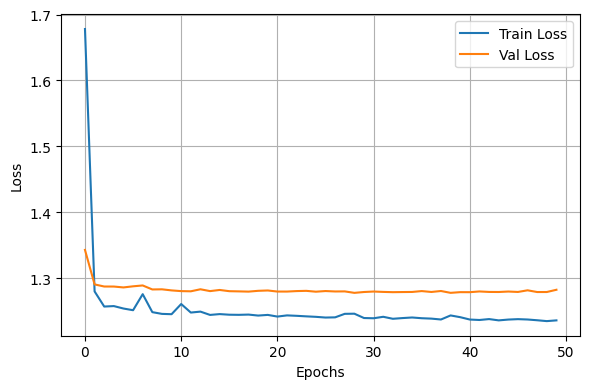

---
Test Loss: 0.6273
---
Prediction 1: [157.65 157.64 157.61 157.6   95.   108.   358.   322.  ]
Actual 1: [157.66 157.65 157.62 157.61   2.   302.   430.   861.  ]
---
Prediction 2: [157.66 157.65 157.62 157.6   93.   107.   359.   322.  ]
Actual 2: [157.66 157.65 157.61 157.6    2.   402.   961.   153.  ]
---
Prediction 3: [157.66 157.65 157.63 157.61  92.   106.   359.   323.  ]
Actual 3: [157.68 157.67 157.65 157.63 206.     4.   100.   200.  ]
---
Prediction 4: [157.68 157.67 157.64 157.63  88.   105.   360.   324.  ]
Actual 4: [157.65 157.64 157.61 157.6  100.    23.   961.   653.  ]
---
Prediction 5: [157.66 157.64 157.62 157.6   94.   107.   358.   322.  ]
Actual 5: [ 157.67  157.65  157.61  157.6   106.    100.   1361.     53.  ]


In [5]:
## Model definition
# Inherit from Decoder in AE_simple.py
class MultiTaskDecoder(Decoder):
    def __init__(self, state_dim, action_dim, hidden_dim, num_layers, output_dims):
        super(MultiTaskDecoder, self).__init__(state_dim, action_dim, hidden_dim, hidden_dim, num_layers)
        
        # Separate output layers for price and volume
        self.price_decoder = nn.Linear(hidden_dim, output_dims['price'])
        self.volume_decoder = nn.Linear(hidden_dim, output_dims['volume'])

    def forward(self, state, action):
        # Use the forward method from the Decoder class for the shared layers
        x = super(MultiTaskDecoder, self).forward(state, action)
        
        # Separate predictions for price and volume
        price_pred = self.price_decoder(x)
        volume_pred = self.volume_decoder(x)
        
        # Combine predictions
        return torch.cat((price_pred, volume_pred), dim=1)

# Define the MultiTaskAutoencoder
class MultiTaskAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers):
        super(MultiTaskAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, state_dim, num_layers)
        self.decoder = MultiTaskDecoder(state_dim, action_dim, hidden_dim, num_layers, output_dims)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


## Model Training
def train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        autoencoder.train()
        total_train_loss = 0
        prev_state = torch.zeros((batch_size, state_dim))  # initialize prev_state as 0
        prev_action = torch.zeros((batch_size, action_dim))  # initialize prev_action as 0

        for obs, action, next_obs, _, _ in train_loader:
            optimizer.zero_grad()
            prediction, state = autoencoder(obs, action, prev_state, prev_action)

            # Separate loss for price and volume
            loss_price = criterion(prediction[:, :4], next_obs[:, :4])
            loss_volume = criterion(prediction[:, 4:], next_obs[:, 4:])
            loss = loss_price + loss_volume
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            prev_state = state.detach()  # update prev_state with the current state
            prev_action = action.detach()  # update prev_actionwith the current action
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        autoencoder.eval()
        total_val_loss = 0
        with torch.no_grad():
            prev_state = torch.zeros((batch_size, state_dim))
            prev_action = torch.zeros((batch_size, action_dim))

            for obs, action, next_obs, _, _ in val_loader:
                prediction, state = autoencoder(obs, action, prev_state, prev_action)
                # Separate loss for price and volume
                loss_price = criterion(prediction[:, :4], next_obs[:, :4])
                loss_volume = criterion(prediction[:, 4:], next_obs[:, 4:])
                loss = loss_price + loss_volume
                total_val_loss += loss.item()

                prev_state = state.detach()
                prev_action = action.detach()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Instantiate and train the model
autoencoder = MultiTaskAutoencoder(input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)

### AE_MT_Attention

Epoch 1, Train Loss: 1.6234, Val Loss: 1.3187
Epoch 2, Train Loss: 1.2773, Val Loss: 1.2930
Epoch 3, Train Loss: 1.2609, Val Loss: 1.2866
Epoch 4, Train Loss: 1.2523, Val Loss: 1.2862
Epoch 5, Train Loss: 1.2569, Val Loss: 1.2856
Epoch 6, Train Loss: 1.2506, Val Loss: 1.2847
Epoch 7, Train Loss: 1.2560, Val Loss: 1.2836
Epoch 8, Train Loss: 1.2495, Val Loss: 1.2843
Epoch 9, Train Loss: 1.2490, Val Loss: 1.2843
Epoch 10, Train Loss: 1.2503, Val Loss: 1.2834
Epoch 11, Train Loss: 1.2476, Val Loss: 1.2845
Epoch 12, Train Loss: 1.2519, Val Loss: 1.2829
Epoch 13, Train Loss: 1.2490, Val Loss: 1.2827
Epoch 14, Train Loss: 1.2475, Val Loss: 1.2824
Epoch 15, Train Loss: 1.2476, Val Loss: 1.2837
Epoch 16, Train Loss: 1.2467, Val Loss: 1.2820
Epoch 17, Train Loss: 1.2463, Val Loss: 1.2823
Epoch 18, Train Loss: 1.2450, Val Loss: 1.2816
Epoch 19, Train Loss: 1.2453, Val Loss: 1.2853
Epoch 20, Train Loss: 1.2491, Val Loss: 1.2808
Epoch 21, Train Loss: 1.2442, Val Loss: 1.2796
Epoch 22, Train Loss: 

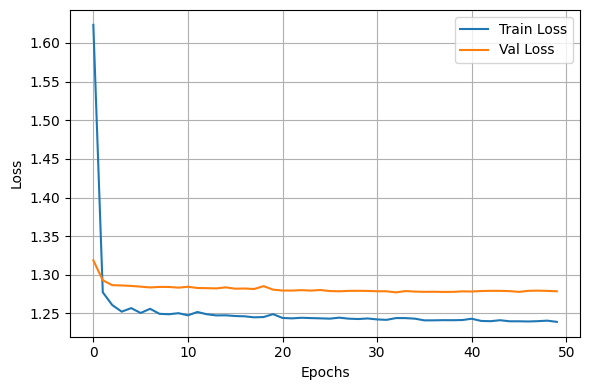

---
Test Loss: 0.6270
---
Prediction 1: [157.65 157.64 157.61 157.6   94.   107.   358.   323.  ]
Actual 1: [157.66 157.65 157.62 157.61   2.   302.   430.   861.  ]
---
Prediction 2: [157.66 157.64 157.62 157.6   93.   107.   358.   323.  ]
Actual 2: [157.66 157.65 157.61 157.6    2.   402.   961.   153.  ]
---
Prediction 3: [157.66 157.65 157.62 157.6   93.   107.   358.   324.  ]
Actual 3: [157.68 157.67 157.65 157.63 206.     4.   100.   200.  ]
---
Prediction 4: [157.67 157.66 157.63 157.62  90.   106.   359.   326.  ]
Actual 4: [157.65 157.64 157.61 157.6  100.    23.   961.   653.  ]
---
Prediction 5: [157.65 157.64 157.61 157.6   94.   107.   358.   323.  ]
Actual 5: [ 157.67  157.65  157.61  157.6   106.    100.   1361.     53.  ]


In [6]:
## Model definition
# Define the Attention Mechanism
class Attention(nn.Module):
    def __init__(self, input_dim, attention_dim):
        super(Attention, self).__init__()
        self.query_layer = nn.Linear(input_dim, attention_dim)
        self.key_layer = nn.Linear(input_dim, attention_dim)
        self.value_layer = nn.Linear(input_dim, attention_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
         # Ensure x is 3D: (batch_size, seq_len, feature_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add a dimension to make it 3D
        # Query, Key, Value
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Scaled Dot-Product Attention
        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (key.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)

        # Apply attention weights to the values
        attended_values = torch.bmm(attention_weights, value)
        return attended_values, attention_weights

# Define the Encoder with Attention
class EncoderWithAttention(Encoder):
    def __init__(self, input_dim, hidden_dim, state_dim, num_layers, attention_dim):
        # Initialize the parent class (Encoder)
        super(EncoderWithAttention, self).__init__(input_dim, hidden_dim, state_dim, num_layers)
        # Add attention layer
        self.attention = Attention(input_dim, attention_dim)
    
    def forward(self, observation, prev_state, prev_action):
        # Combine observation, previous state, and previous action
        x = torch.cat((observation, prev_state, prev_action), dim=1)
        # Apply attention mechanism before passing through the hidden layers
        x, _ = self.attention(x)
        # Pass through the hidden layers from the parent class
        for layer in self.hidden_layers:
            x = F.leaky_relu(layer(x))
        return x.squeeze(1)


# Define the Autoencoder
class AutoencoderWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim):
        super(AutoencoderWithAttention, self).__init__()
        self.encoder = EncoderWithAttention(input_dim, hidden_dim, state_dim, num_layers, attention_dim)
        self.decoder = MultiTaskDecoder(state_dim, action_dim, hidden_dim, num_layers, output_dims)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


# Instantiate and train the model
autoencoder = AutoencoderWithAttention(input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)

### AE_MT_AT_CNN

Epoch 1, Train Loss: 1.7472, Val Loss: 1.3118
Epoch 2, Train Loss: 1.2638, Val Loss: 1.2933
Epoch 3, Train Loss: 1.2563, Val Loss: 1.2917
Epoch 4, Train Loss: 1.2537, Val Loss: 1.2898
Epoch 5, Train Loss: 1.2546, Val Loss: 1.2881
Epoch 6, Train Loss: 1.2514, Val Loss: 1.2869
Epoch 7, Train Loss: 1.2498, Val Loss: 1.2860
Epoch 8, Train Loss: 1.2499, Val Loss: 1.2843
Epoch 9, Train Loss: 1.2477, Val Loss: 1.2839
Epoch 10, Train Loss: 1.2474, Val Loss: 1.2837
Epoch 11, Train Loss: 1.2485, Val Loss: 1.2824
Epoch 12, Train Loss: 1.2449, Val Loss: 1.2828
Epoch 13, Train Loss: 1.2445, Val Loss: 1.2825
Epoch 14, Train Loss: 1.2456, Val Loss: 1.2849
Epoch 15, Train Loss: 1.2542, Val Loss: 1.2810
Epoch 16, Train Loss: 1.2432, Val Loss: 1.2802
Epoch 17, Train Loss: 1.2428, Val Loss: 1.2805
Epoch 18, Train Loss: 1.2435, Val Loss: 1.2806
Epoch 19, Train Loss: 1.2450, Val Loss: 1.2814
Epoch 20, Train Loss: 1.2457, Val Loss: 1.2803
Epoch 21, Train Loss: 1.2420, Val Loss: 1.2804
Epoch 22, Train Loss: 

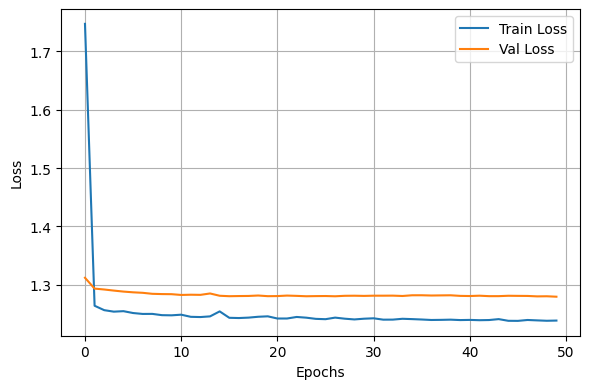

---
Test Loss: 0.6274
---
Prediction 1: [157.65 157.64 157.61 157.6   97.   107.   356.   322.  ]
Actual 1: [157.66 157.65 157.62 157.61   2.   302.   430.   861.  ]
---
Prediction 2: [157.66 157.64 157.62 157.6   95.   107.   358.   323.  ]
Actual 2: [157.66 157.65 157.61 157.6    2.   402.   961.   153.  ]
---
Prediction 3: [157.66 157.65 157.62 157.61  94.   107.   358.   323.  ]
Actual 3: [157.68 157.67 157.65 157.63 206.     4.   100.   200.  ]
---
Prediction 4: [157.67 157.66 157.63 157.62  90.   106.   360.   324.  ]
Actual 4: [157.65 157.64 157.61 157.6  100.    23.   961.   653.  ]
---
Prediction 5: [157.65 157.64 157.61 157.6   96.   107.   357.   322.  ]
Actual 5: [ 157.67  157.65  157.61  157.6   106.    100.   1361.     53.  ]


In [7]:
## Model definition
class EncoderWithAttentionAndCNN(EncoderWithAttention):
    def __init__(self, input_dim, hidden_dim, state_dim, num_layers, attention_dim, conv_filters, kernel_size):
        # Initialize the parent class (EncoderWithAttention)
        super(EncoderWithAttentionAndCNN, self).__init__(input_dim, hidden_dim, state_dim, num_layers, attention_dim)
        # Add 1D Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=conv_filters, kernel_size=kernel_size, padding=kernel_size//2)
        # Override attention layer to match the output of conv1d
        self.attention = Attention(conv_filters, attention_dim)
        # Override hidden layers
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(conv_filters, hidden_dim))
        for _ in range(num_layers - 2):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        if num_layers > 1:
            self.hidden_layers.append(nn.Linear(hidden_dim, state_dim))
        else:
            self.hidden_layers[0] = nn.Linear(conv_filters, state_dim)

    def forward(self, observation, prev_state, prev_action):
        # Combine observation, previous state, and previous action
        x = torch.cat((observation, prev_state, prev_action), dim=1)
        # Apply attention mechanism before passing through the hidden layers
        if x.dim() == 2:  # Ensure x is 3D: (batch_size, seq_len, feature_dim)
            x = x.unsqueeze(1)
        # Apply 1D Convolution
        x = x.permute(0, 2, 1)  # Change dimension to (batch_size, feature_dim, seq_len)
        x = F.relu(self.conv1d(x))
        x = x.permute(0, 2, 1)  # Change back to (batch_size, seq_len, conv_filters)
        # Apply attention mechanism (inherited from EncoderWithAttention)
        x, _ = self.attention(x)
        # Pass through the hidden layers (inherited from EncoderWithAttention)
        for layer in self.hidden_layers:
            x = F.leaky_relu(layer(x))
        return x.squeeze(1)


# Define the Autoencoder
class AutoencoderWithAttentionAndCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim, conv_filters, kernel_size):
        super(AutoencoderWithAttentionAndCNN, self).__init__()
        self.encoder = EncoderWithAttentionAndCNN(input_dim, hidden_dim, state_dim, num_layers, attention_dim, conv_filters, kernel_size)
        self.decoder = MultiTaskDecoder(state_dim, action_dim, hidden_dim, num_layers, output_dims)

    def forward(self, observation, action, prev_state, prev_action):
        state = self.encoder(observation, prev_state, prev_action)
        prediction = self.decoder(state, action)
        return prediction, state


# Instantiate and train the model
autoencoder = AutoencoderWithAttentionAndCNN(input_dim, hidden_dim, state_dim, action_dim, output_dims, num_layers, attention_dim, conv_filters, kernel_size)
train_autoencoder_with_validation(autoencoder, train_loader, val_loader, epochs, learning_rate, batch_size, state_dim, action_dim)
evaluate_on_test(autoencoder, test_loader, batch_size, state_dim, action_dim)